# <center> Training pipeline </center>

In [2]:
import time
import warnings

import gym
import matplotlib.pyplot as plt
import numpy as np

from environments import (
    DiscreteStockEnvironment,
    DiscreteTradingEnvironment,
    TradingStockEnvironment,
    TrainStockEnvironment,
)

from utils import compute_mv_weights

## I] Discrete Setting

### 1. Environments

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


<Axes: >

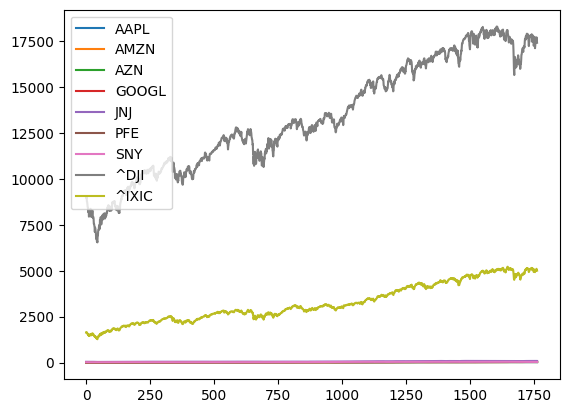

In [3]:
env = DiscreteStockEnvironment(max_shares_per_stock=2, initial_fund=100_000)
eval_env = DiscreteTradingEnvironment(max_shares_per_stock=2, initial_fund=100_000)


env.stocks_df["Adj Close"].plot()

In [4]:
eval_env.stocks_df["Adj Close"].mean()

AAPL        43.863806
AMZN        70.470815
AZN         32.360822
GOOGL       52.610694
JNJ        114.298096
PFE         28.982796
SNY         36.812994
^DJI     23152.762022
^IXIC     6975.093574
dtype: float64

### 2. Benchmark

In [5]:
cov_matrix = env.stocks_df["Adj Close"].cov()
n = len(env.ticker)
w0 = np.ones(n)/n
benchmark_weights = {"min variance": compute_mv_weights(w0, cov_matrix)}

### 3. Agent training

In [32]:
from agents import A2C

MAX_STEPS = 10
EPISODES_BEFORE_TRAIN = 0

# roll out n steps
ROLL_OUT_N_STEPS = 5
# only remember the latest ROLL_OUT_N_STEPS
MEMORY_CAPACITY = ROLL_OUT_N_STEPS
# only use the latest ROLL_OUT_N_STEPS for training A2C
BATCH_SIZE = ROLL_OUT_N_STEPS

REWARD_DISCOUNTED_GAMMA = 0.99
ENTROPY_REG = 0.00
DONE_PENALTY = 0

CRITIC_LOSS = "mse"
MAX_GRAD_NORM = None

EPSILON_START = 0.99
EPSILON_END = 0.05
EPSILON_DECAY = 500

RANDOM_SEED = 42


def train_my_a2c_agent(env: gym.Env):
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    a2c = A2C(
        env=env,
        memory_capacity=MEMORY_CAPACITY,
        state_dim=state_dim,
        action_dim=action_dim,
        batch_size=BATCH_SIZE,
        entropy_reg=ENTROPY_REG,
        done_penalty=DONE_PENALTY,
        roll_out_n_steps=ROLL_OUT_N_STEPS,
        reward_gamma=REWARD_DISCOUNTED_GAMMA,
        epsilon_start=EPSILON_START,
        epsilon_end=EPSILON_END,
        epsilon_decay=EPSILON_DECAY,
        max_grad_norm=MAX_GRAD_NORM,
        episodes_before_train=EPISODES_BEFORE_TRAIN,
        critic_loss=CRITIC_LOSS,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        while a2c.n_steps < MAX_STEPS:
            a2c.interact()
            a2c.train()
    
    return a2c

my_a2c = train_my_a2c_agent(env)

### 4. Agent evaluation

In [6]:
import gym
import torch

def test_agent(agent: A2C, env: gym.Env) -> gym.Env:
    # initiate environment
    obs = env.reset()
    rewards = []    # iterate
    done = False
    while not done:
        # Select next action
        action = agent.action(obs)
        obs, reward, done, _ = env.step(action)
        rewards.append(reward/env.window_day_duration)
    
    print(f"mean daily reward: {np.array(rewards).mean()}")
    
    env.close()
    
    return env

In [17]:
import warnings

eval_env.turbulence_threshold = 120

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_env = test_agent(my_a2c, eval_env)

mean daily reward: 44.070956218822225


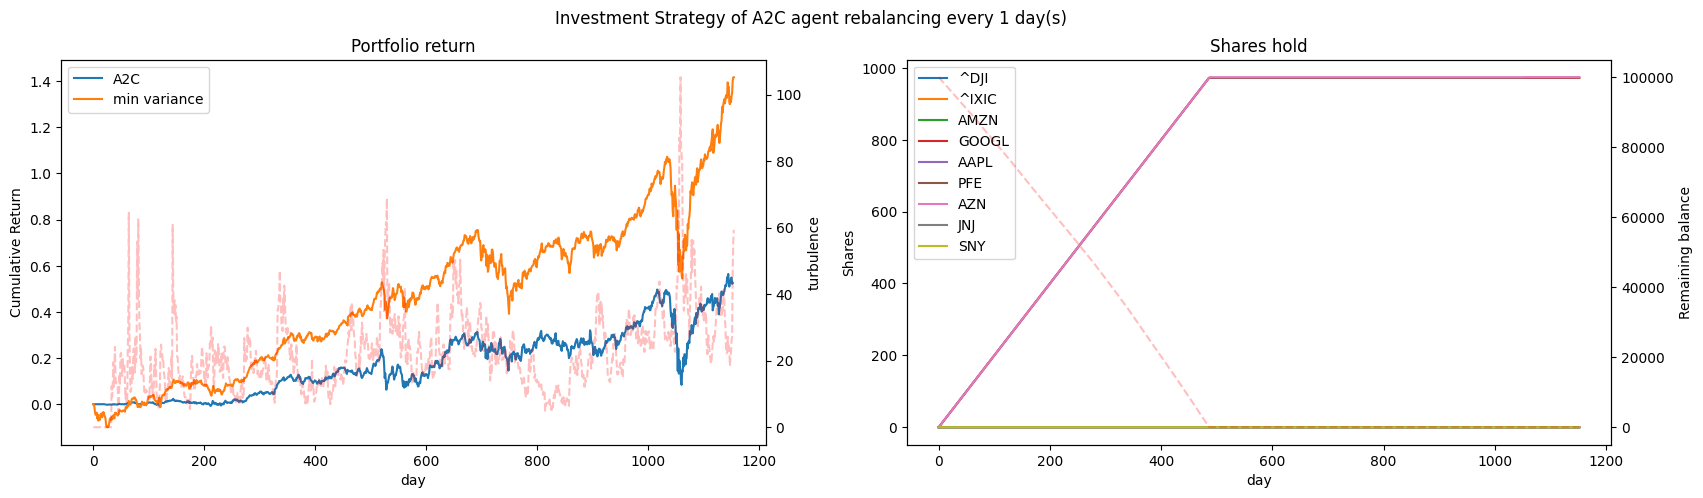

In [18]:
eval_env.render("A2C", benchmark_weights=benchmark_weights)

## II] Continuous Setting

### 1. Envrionments

In [15]:
env = TrainStockEnvironment(max_shares_per_stock=1000, initial_fund=1_000_000, window_day_duration=5)
eval_env = TradingStockEnvironment(max_shares_per_stock=1000, initial_fund=1_000_000, window_day_duration=5)

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed


### 2. Agent training

In [16]:
from stable_baselines3 import A2C, DDPG, PPO

def train_A2C(env_train, timesteps=25000):
    """A2C model"""

    start = time.time()
    model = A2C('MlpPolicy', env_train, verbose=0, gamma=0)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    print('Training time (A2C): ', (end - start) / 60, ' minutes')
    
    return model

trained_a2c = train_A2C(env, 100)

Training time (A2C):  0.012313584486643473  minutes


In [8]:
import gym

def test_agent(agent: A2C, env: gym.Env) -> gym.Env:
    # initiate environment
    obs = env.reset()
    rewards = []    # iterate
    done = False
    while not done:
        # Select next action
        action = agent.predict(obs, deterministic=True)[0]
        obs, reward, done, _ = env.step(action)
        rewards.append(reward/env.window_day_duration)
    
    print(f"mean daily reward: {np.array(rewards).mean()}")
    
    env.close()
    # env.render()
    
    return env

In [17]:
import warnings

eval_env.turbulence_threshold = 120

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    eval_env = test_agent(trained_a2c, eval_env)

mean daily reward: 1143.8775889126985


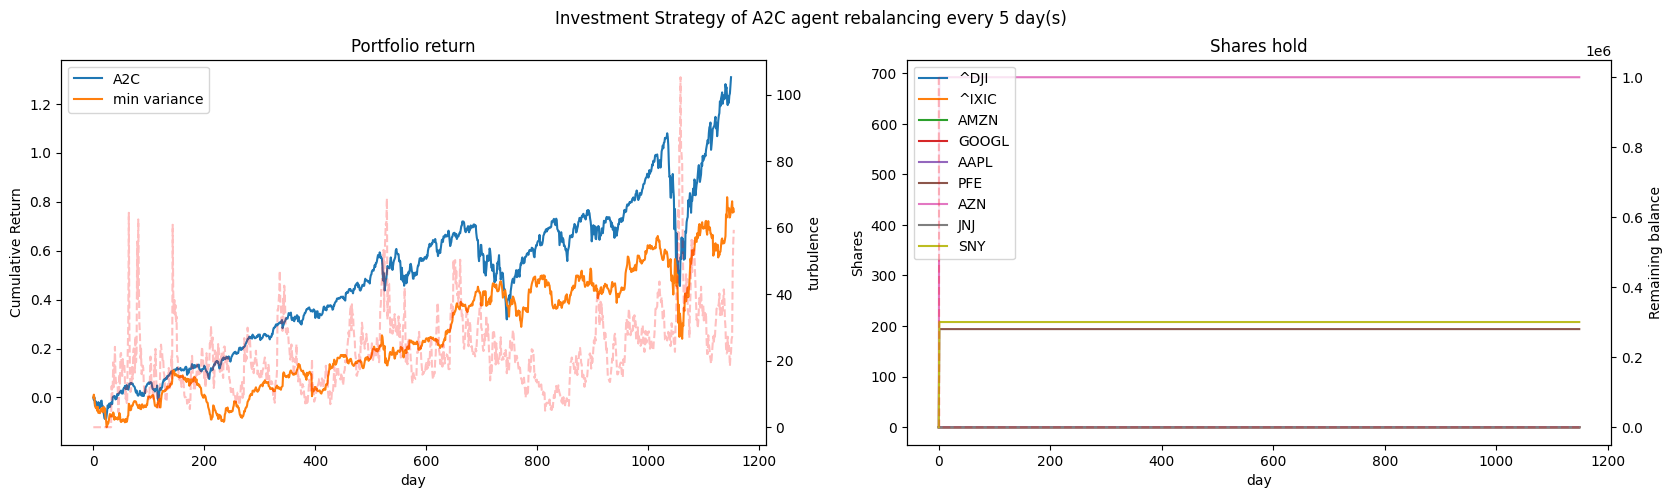

In [18]:
eval_env.render("A2C", benchmark_weights=benchmark_weights)

## III] Stock Data investigation

<Axes: >

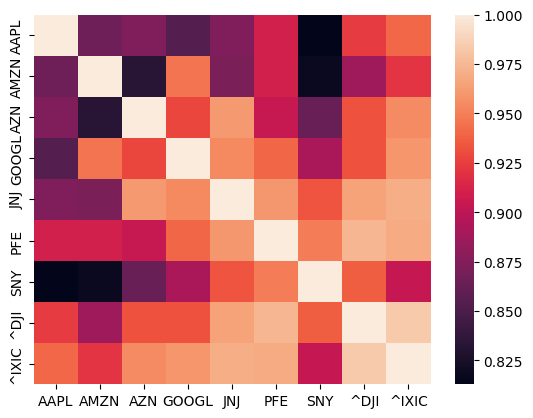

In [21]:
import seaborn as sns

sns.heatmap(env.stocks_df["Adj Close"].corr())

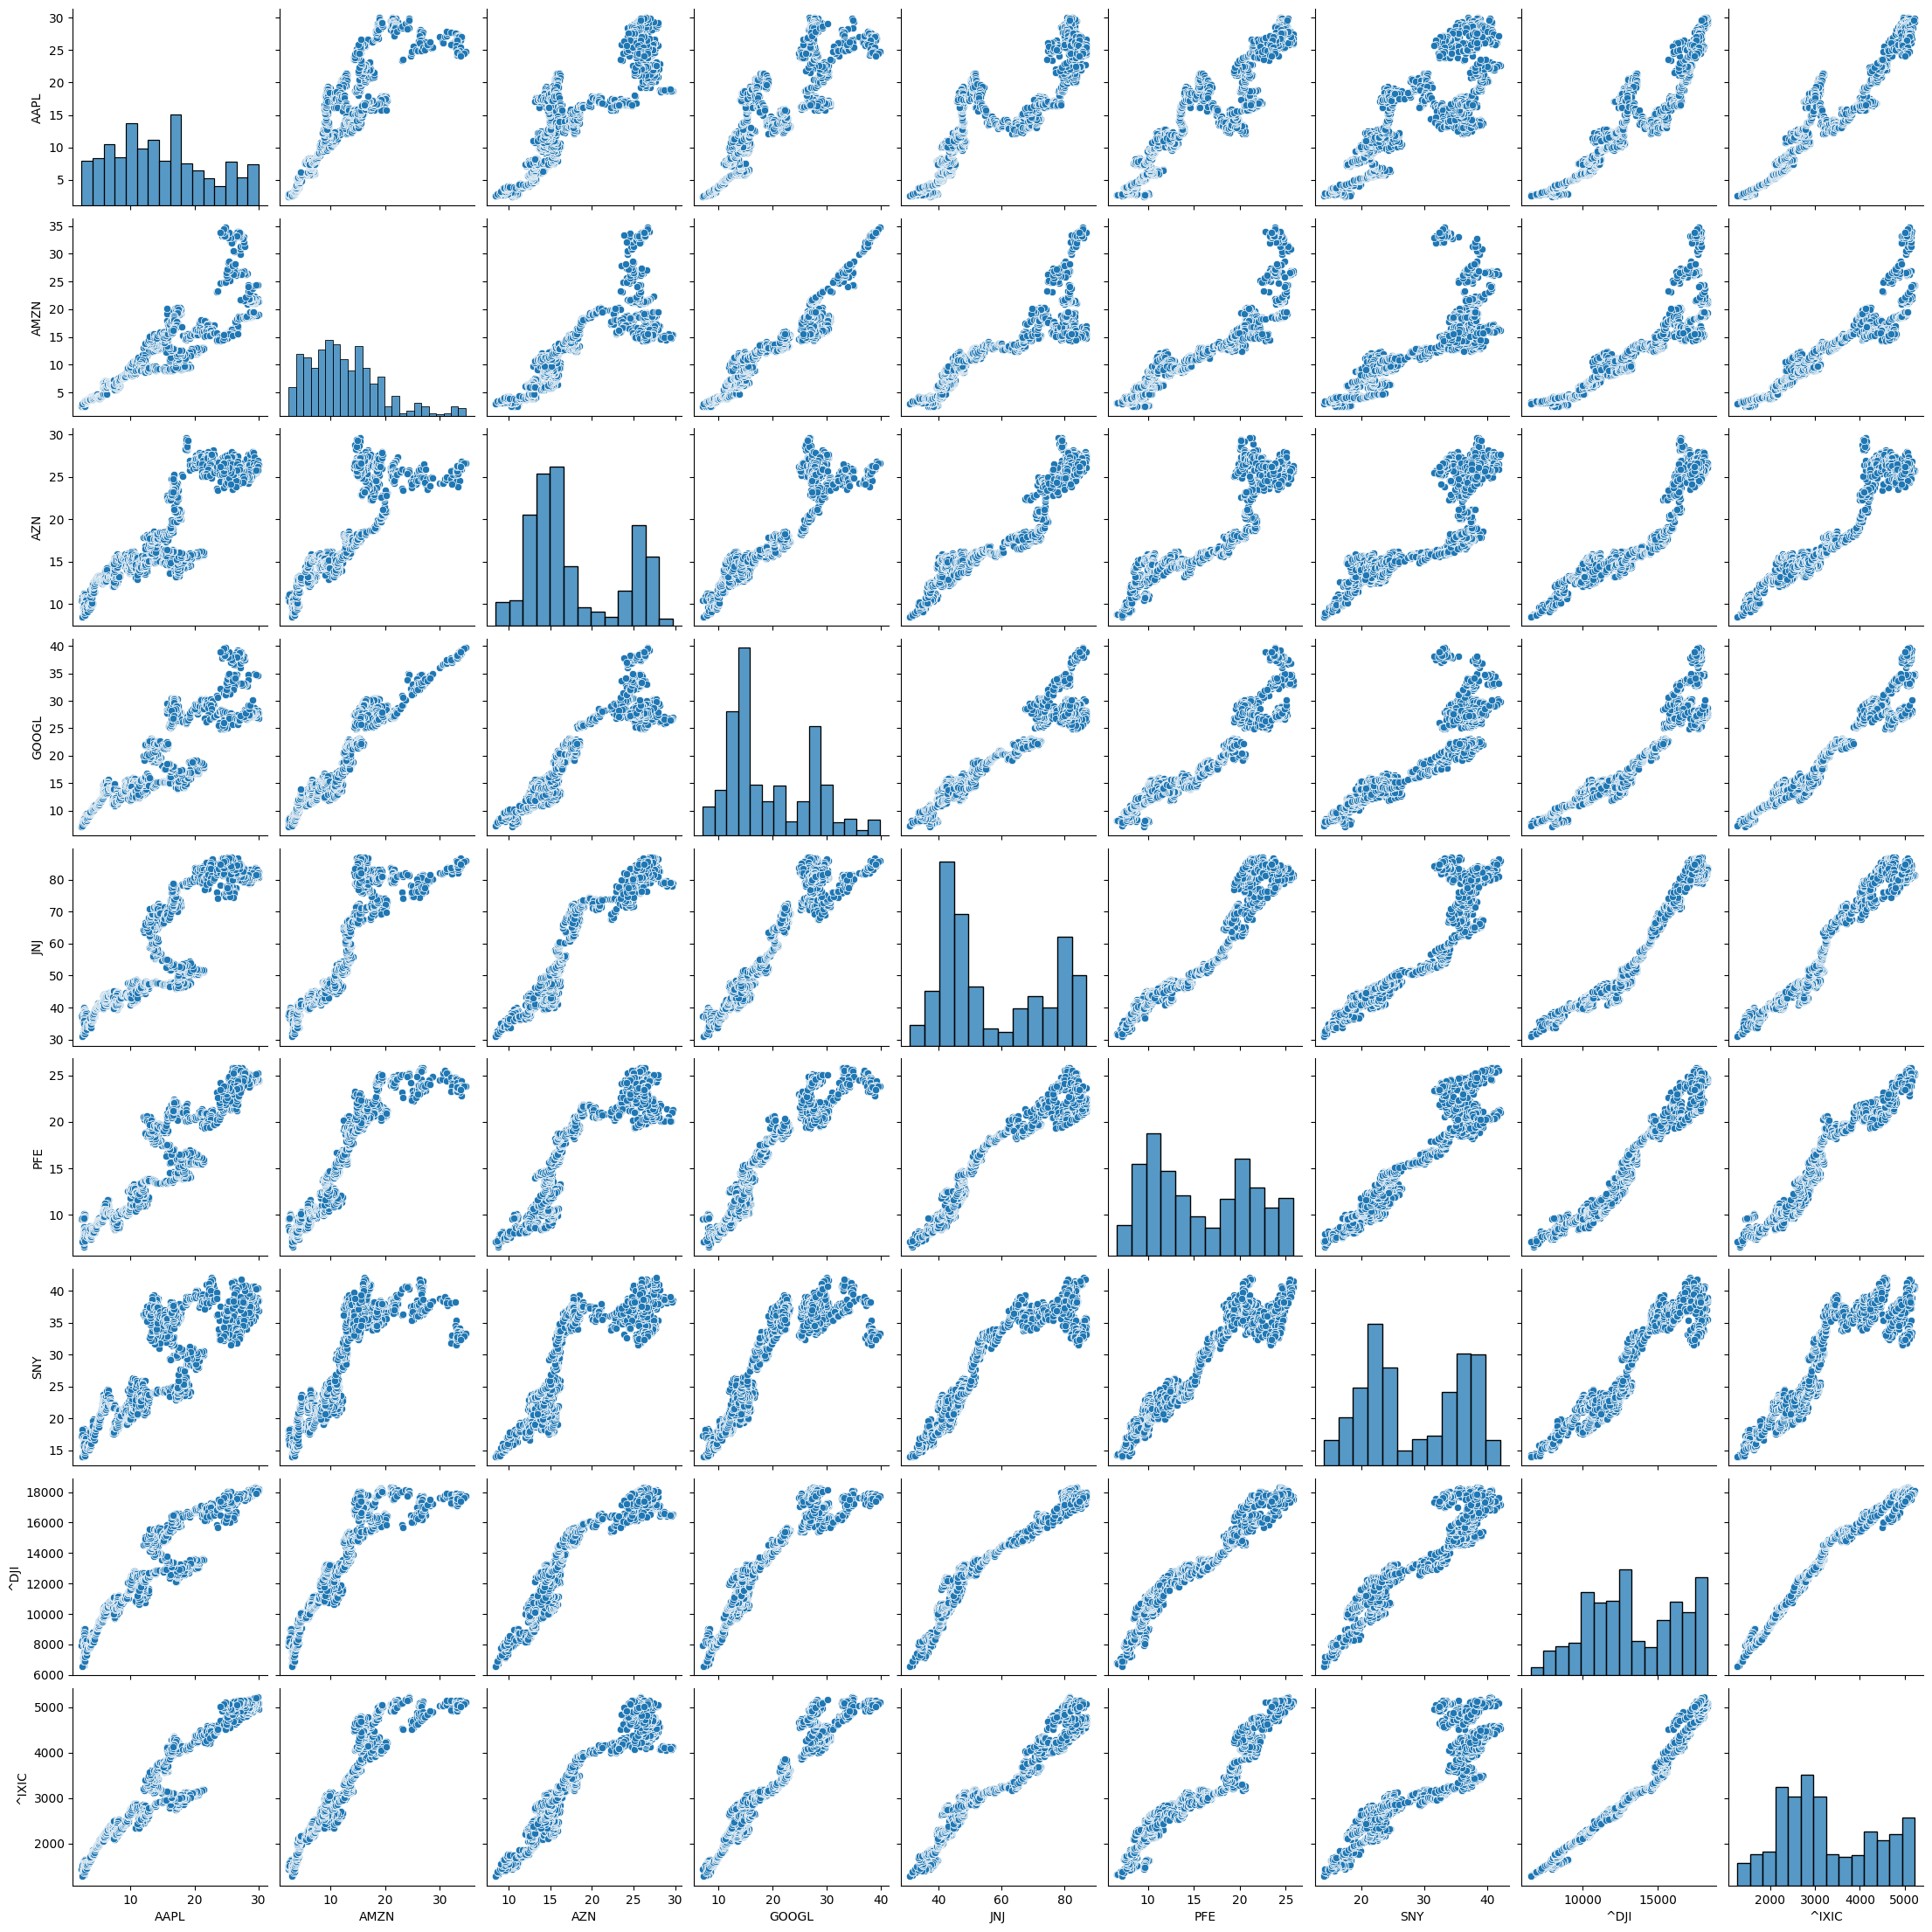

In [22]:
sns.pairplot(env.stocks_df["Adj Close"])

[]

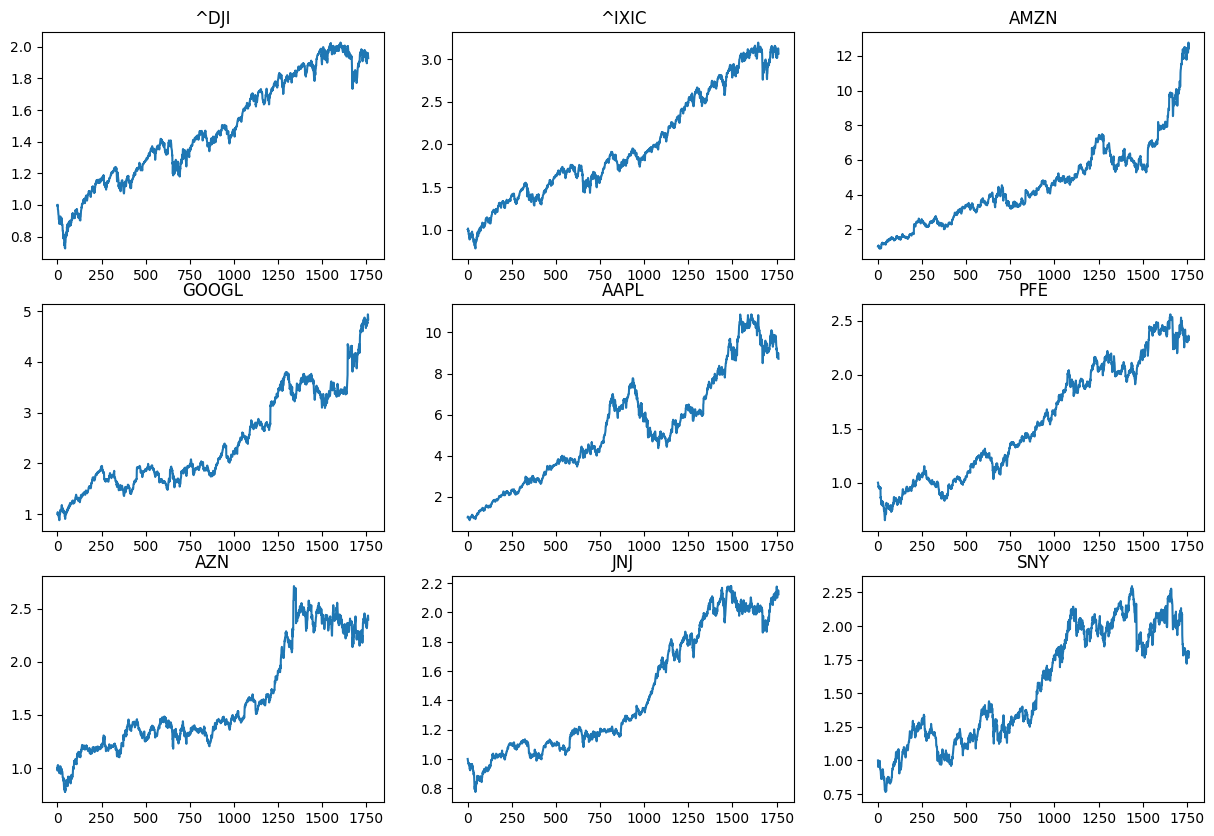

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for i, stock in enumerate(env.ticker):
    axes[i//3, i%3].plot(env.stocks_df["Adj Close"][stock]/env.stocks_df["Adj Close"][stock].iloc[0])
    axes[i//3, i%3].set_title(stock)

plt.plot()

[]

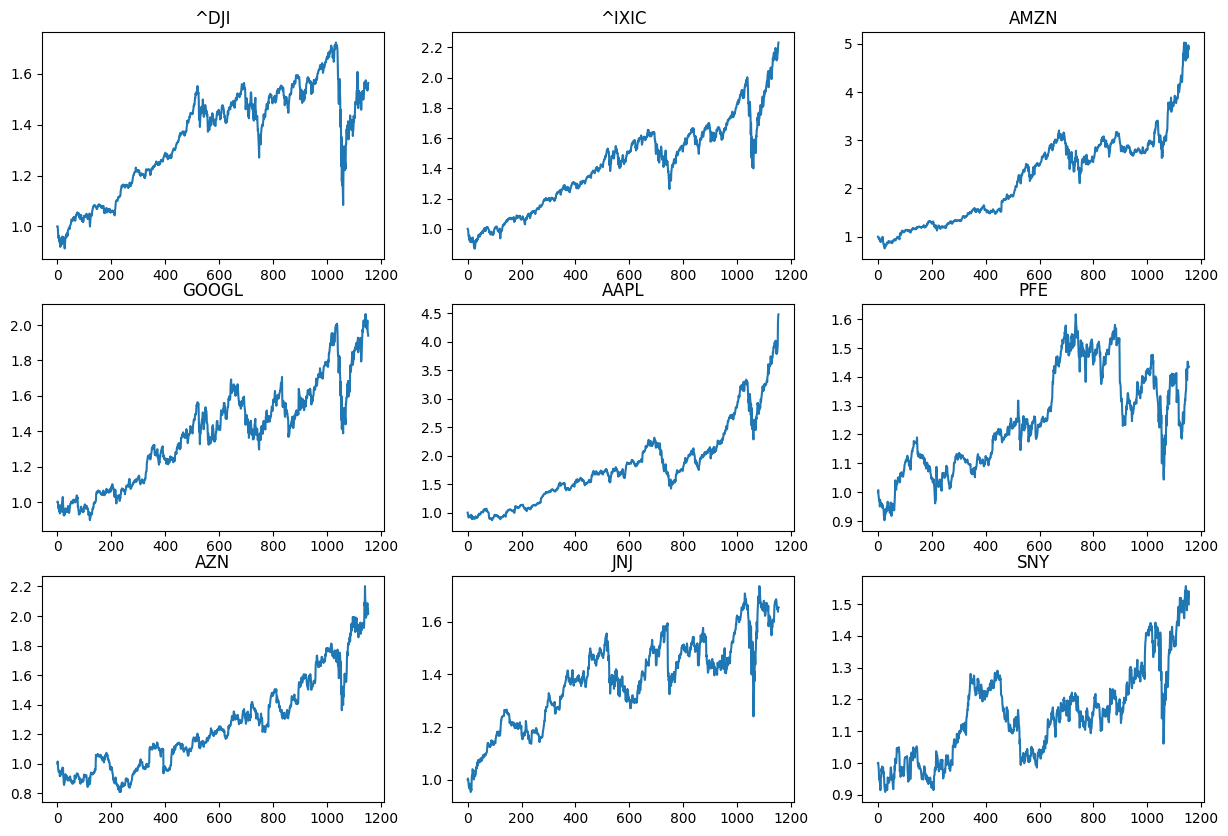

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for i, stock in enumerate(env.ticker):
    axes[i//3, i%3].plot(eval_env.stocks_df["Adj Close"][stock]/eval_env.stocks_df["Adj Close"][stock].iloc[0])
    axes[i//3, i%3].set_title(stock)

plt.plot()